In [2]:
import os
import warnings
from google.cloud import storage
warnings.filterwarnings("ignore", category=UserWarning)
import xml.etree.ElementTree as ET
import pandas as pd
from datetime import datetime
from pathlib import Path
from tqdm.notebook import tqdm
import time
from sklearn.preprocessing import MinMaxScaler
import numpy as np

from datetime import timedelta
# Libraries to help with data visualization
import matplotlib.pyplot as plt
import seaborn as sns
import random
# Command to tell Python to actually display the graphs
%matplotlib inline

In [35]:
def junit_xml_to_df(junits: [], jobs: []) -> pd.DataFrame:
    all_job_test_results = {}

    for idx, junit in enumerate(junits):
        flakes = []
        try:
            root = ET.fromstring(junit)
        except:
            continue
        #root = ET.parse(junit).getroot()
        job = jobs[idx]

        tests_count = root.get("tests")
        if int(tests_count) <= 1000:
            continue

        for testcase in root.iter('testcase'):
            testname = testcase.get('name')

            if testname in flakes:
                continue

            skipped = testcase.find('skipped')
            failure = testcase.find('failure')

            if all_job_test_results.get(testname) is None:
                all_job_test_results[testname] = {}

            if skipped is not None:
                continue

            test_state = 1
            if failure is not None:
                if "flake" in failure.text:
                    flakes.append(testname)
                    continue
                test_state = 0

            if all_job_test_results[testname].get(job) is None:
                all_job_test_results[testname][job] = test_state
            else:
                if all_job_test_results[testname][job] != test_state:
                    if all_job_test_results[testname][job] == 0:
                        continue
                    else:
                        all_job_test_results[testname][job] = test_state


    df = pd.DataFrame.from_dict(all_job_test_results, orient='index')

    # convert columns to panda datetime
    df.columns = pd.to_datetime(df.columns)
    return df


In [36]:
def get_junit_xml_from_gcs(job_prefix: str) -> ([], []):
    junits = []
    jobs = []

    bucket_name = "test-platform-results"

    print(f"Starting {job_prefix}", end='')
    try:
        storage_client = storage.Client(project=None)
        bucket = storage_client.get_bucket(bucket_name)
        prefix = f"pr-logs/directory/{job_prefix}"
        blobs = bucket.list_blobs(prefix=prefix)
    except:
        return junits, jobs

    for blob in blobs:
        try:
            path_to_job_artifacts = blob.download_as_text()
            # split on the bucket_name and remove the first /
            prefix = (path_to_job_artifacts.split(bucket_name)[-1])[1:-1]

            junit_blobs = bucket.list_blobs(prefix=prefix, match_glob="**junit_e2e*.xml")
        except:
            continue

        for junit_blob in junit_blobs:
            if "junit_e2e" in junit_blob.name:
                print('.', end='')
                filename = Path(junit_blob.name).name
                datetime_str = filename.split('__')[1].split('.')[0]
                jobs.append(datetime_str)
                try:
                    junits.append(junit_blob.download_as_text())
                except:
                    continue

    print('')
    return junits, jobs

In [37]:

branches = []
repos = []


repo_jobs = [
    "pull-ci-openshift-installer-main-e2e-vsphere-ovn-upi",
    "pull-ci-openshift-installer-main-e2e-vsphere-ovn",
    "pull-ci-openshift-installer-main-e2e-vsphere-ovn-zones",
    "pull-ci-openshift-installer-main-e2e-vsphere-ovn-zones-techpreview",
    "pull-ci-openshift-installer-main-e2e-vsphere-multi-vcenter-ovn",
    "pull-ci-openshift-installer-main-e2e-vsphere-ovn-upi-zones",
    "pull-ci-openshift-installer-main-e2e-vsphere-ovn-multi-disk",
    "pull-ci-openshift-installer-main-e2e-vsphere-static-ovn",
    "pull-ci-openshift-installer-main-e2e-vsphere-ovn-techpreview",
    "pull-ci-openshift-installer-main-e2e-vsphere-externallb-ovn",
    "pull-ci-openshift-cluster-cloud-controller-manager-operator-master-e2e-vsphere-ovn",
    "pull-ci-openshift-cluster-control-plane-machine-set-operator-main-e2e-vsphere-operator",
    "pull-ci-openshift-cluster-control-plane-machine-set-operator-main-e2e-vsphere-multi-zone-operator",
    "pull-ci-openshift-cluster-control-plane-machine-set-operator-main-e2e-vsphere-multi-vcenter-operator",
    "pull-ci-openshift-cluster-network-operator-master-e2e-vsphere-ovn",
    "pull-ci-openshift-cluster-network-operator-master-e2e-vsphere-ovn-dualstack",
    "pull-ci-openshift-cluster-network-operator-master-e2e-vsphere-ovn-dualstack-primaryv6",
    "pull-ci-openshift-cluster-storage-operator-main-e2e-vsphere-csi",
    "pull-ci-openshift-csi-external-attacher-master-e2e-vsphere",
    "pull-ci-openshift-csi-external-attacher-master-e2e-vsphere-csi",
    "pull-ci-openshift-csi-external-provisioner-master-e2e-vsphere",
    "pull-ci-openshift-csi-external-provisioner-master-e2e-vsphere-csi",
    "pull-ci-openshift-csi-external-resizer-master-e2e-vsphere",
    "pull-ci-openshift-csi-external-resizer-master-e2e-vsphere-csi",
    "pull-ci-openshift-csi-external-snapshotter-master-e2e-vsphere",
    "pull-ci-openshift-csi-external-snapshotter-master-e2e-vsphere-csi",
    "pull-ci-openshift-csi-livenessprobe-master-e2e-vsphere",
    "pull-ci-openshift-csi-livenessprobe-master-e2e-vsphere-csi",
    "pull-ci-openshift-csi-node-driver-registrar-master-e2e-vsphere",
    "pull-ci-openshift-csi-node-driver-registrar-master-e2e-vsphere-csi",
    "pull-ci-openshift-machine-api-operator-main-e2e-vsphere-ovn-serial",
    "pull-ci-openshift-machine-api-operator-main-e2e-vsphere-ovn",
    "pull-ci-openshift-machine-api-operator-main-e2e-vsphere-ovn-multi-vcenter",
    "pull-ci-openshift-machine-api-operator-main-e2e-vsphere-operator",
    "pull-ci-openshift-machine-api-operator-main-e2e-vsphere-ovn-upgrade",
    "pull-ci-openshift-machine-api-operator-main-e2e-vsphere-static-ovn",
    "pull-ci-openshift-machine-config-operator-main-e2e-vsphere-ovn-upi",
    "pull-ci-openshift-machine-config-operator-main-e2e-vsphere-ovn-upi-zones",
    "pull-ci-openshift-machine-config-operator-main-e2e-vsphere-ovn-zones",
    "pull-ci-openshift-machine-config-operator-main-e2e-vsphere",
    "pull-ci-openshift-machine-config-operator-main-e2e-vsphere-upgrade",
    "pull-ci-openshift-vmware-vsphere-csi-driver-operator-main-e2e-vsphere",
    "pull-ci-openshift-vmware-vsphere-csi-driver-operator-main-e2e-vsphere-operator-test",
    "pull-ci-openshift-vmware-vsphere-csi-driver-operator-main-e2e-vsphere-csi",
    "pull-ci-openshift-vmware-vsphere-csi-driver-operator-main-e2e-vsphere-ovn-upgrade",
    "pull-ci-openshift-vmware-vsphere-csi-driver-operator-main-e2e-vsphere-csi-extended",
    "pull-ci-openshift-vmware-vsphere-csi-driver-operator-main-e2e-vsphere-zones",
    "pull-ci-openshift-vmware-vsphere-csi-driver-master-e2e-vsphere",
    "pull-ci-openshift-vmware-vsphere-csi-driver-master-e2e-vsphere-csi",
    "pull-ci-openshift-vmware-vsphere-csi-driver-master-e2e-vsphere-ovn-upgrade",
    "pull-ci-openshift-vmware-vsphere-csi-driver-master-e2e-vsphere-csi-extended",
    "pull-ci-openshift-vmware-vsphere-csi-driver-master-e2e-vsphere-zones",
    "pull-ci-openshift-vsphere-problem-detector-main-e2e-vsphere",
    "pull-ci-openshift-vsphere-problem-detector-main-e2e-vsphere-csi-extended",
    "pull-ci-openshift-vsphere-problem-detector-main-e2e-vsphere-zones",
    "pull-ci-openshift-vsphere-problem-detector-main-e2e-vsphere-host-groups-ovn-custom-no-upgrade",
]

for r in repo_jobs:
    if "main" in r:
        master_repo = r.replace("main", "master")
        if not any(master_repo in x for x in repo_jobs):
            repo_jobs.append(master_repo)

df_list = []

for job in repo_jobs:
    temp_junits, temp_jobs = get_junit_xml_from_gcs(job)

    temp_df = junit_xml_to_df(temp_junits, temp_jobs)

    df_list.append(temp_df)

    temp_df.to_parquet(f"{job}.parquet")

    # try to save some memory
    del temp_junits, temp_jobs

    #all_junits.extend(temp_junits)
    #all_jobs.extend(temp_jobs)

Starting pull-ci-openshift-installer-main-e2e-vsphere-ovn-upi..................................................
Starting pull-ci-openshift-installer-main-e2e-vsphere-ovn..................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................
Starting pull-ci-openshift-installer-main-e2e-vsphere-ovn-zones.............

In [123]:
np.random.seed(42)
random.seed(42)

for tdf in df_list:
    for idx, col in enumerate(tdf.columns):
        # Add random milliseconds to make the column names unique
        random_ms = np.random.randint(0, 1000)
        random_ns = np.random.randint(0, 1000)
        #new_col = col + timedelta(milliseconds=int(random_ms[idx]), microseconds=int(random_ns[idx]))
        new_col = col + timedelta(milliseconds=random_ms, microseconds=random_ns)
        tdf.rename(columns={col: new_col}, inplace=True)


df = pd.concat(df_list, axis=1)

df.sort_index(axis=1, inplace=True)

df.to_parquet("joined.parquet")

In [3]:
df = pd.read_parquet("joined.parquet")

In [49]:
df.index[df.index.duplicated() == True]

Index([], dtype='object')

In [47]:
test_names = df.index.tolist()



from sentence_transformers import SentenceTransformer

from sklearn.metrics.pairwise import cosine_similarity


model = SentenceTransformer('all-MiniLM-L6-v2')

# Get embeddings for test names
embeddings = model.encode(test_names)

# Compute cosine similarity between the embeddings
cos_sim_matrix = cosine_similarity(embeddings)

# Convert the similarity matrix to a DataFrame for better readability
cos_sim_df = pd.DataFrame(cos_sim_matrix, index=test_names, columns=test_names)
print(cos_sim_df)

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

                                                    [sig-instrumentation] Prometheus [apigroup:image.openshift.io] when installed on the cluster shouldn't report any alerts in firing state apart from Watchdog and AlertmanagerReceiversNotConfigured [Early][apigroup:config.openshift.io] [Skipped:Disconnected] [Suite:openshift/conformance/parallel]  \
[sig-instrumentation] Prometheus [apigroup:imag...                                           1.000000                                                                                                                                                                                                                                                         
[sig-scheduling][Early] The openshift-console d...                                           0.621581                                                                                                                                                                                                     

In [37]:
nan = df.isna().sum(axis=1)

In [45]:
nan[nan < 2000]

[sig-instrumentation] Prometheus [apigroup:image.openshift.io] when installed on the cluster shouldn't report any alerts in firing state apart from Watchdog and AlertmanagerReceiversNotConfigured [Early][apigroup:config.openshift.io] [Skipped:Disconnected] [Suite:openshift/conformance/parallel]                                                                                                                           0
[sig-scheduling][Early] The openshift-console downloads pods [apigroup:console.openshift.io] should be scheduled on different nodes [Skipped:SingleReplicaTopology] [Suite:openshift/conformance/parallel]                                                                                                                                                                                                                      113
[sig-scheduling][Early] The openshift-apiserver pods [apigroup:authorization.openshift.io][apigroup:build.openshift.io][apigroup:image.openshift.io][apigroup:pr

In [40]:
nan.describe()

count    1909.000000
mean      908.358827
std      1779.688551
min         0.000000
25%         0.000000
50%         0.000000
75%       113.000000
max      5082.000000
dtype: float64

In [124]:
df.describe()

,2024-09-26 13:53:51.194755,2024-09-26 13:53:51.412715,2024-09-26 13:58:05.276105,2024-09-26 14:01:31.423660,2024-09-26 15:06:05.099680,2024-09-26 15:06:05.563810,2024-09-26 15:06:08.769265,2024-09-26 15:55:54.443260,2024-09-26 15:57:39.460425,2024-09-26 15:57:41.378810,...,2025-03-25 15:20:45.279140,2025-03-25 15:21:36.879285,2025-03-25 15:21:37.389810,2025-03-25 15:26:29.791555,2025-03-25 16:01:27.471800,2025-03-25 16:01:32.658110,2025-03-25 16:01:43.204685,2025-03-25 18:06:28.880915,2025-03-25 18:07:07.977995,2025-03-25 18:07:09.259115
count,1507.0,1507.0,1472.000000,1507.000000,1532.000000,1532.000000,1532.000000,1509.000000,1532.000000,1532.000000,...,1593.000000,1554.000000,1554.000000,1589.000000,1593.000000,1593.000000,1589.000000,1593.000000,1608.000000,1608.000000
mean,1.0,1.0,0.997962,0.999336,0.981070,0.981070,0.981070,0.998675,0.981070,0.981070,...,0.998745,0.998713,0.998713,0.999371,0.999372,0.998745,0.999371,0.998745,0.998756,0.998756
std,0.0,0.0,0.045114,0.025760,0.136321,0.136321,0.136321,0.036394,0.136321,0.136321,...,0.035422,0.035863,0.035863,0.025086,0.025055,0.035422,0.025086,0.035422,0.035256,0.035256
min,1.0,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.0,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
50%,1.0,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
75%,1.0,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
max,1.0,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [121]:
df.head()

,2025-01-23 21:29:19.307305,2025-01-24 22:48:07.580810,2025-01-25 05:53:20.318213,2025-01-27 20:25:13.100060,2025-02-17 13:21:30.842363,2024-12-18 03:11:59.398642,2024-12-18 02:25:04.991374,2024-12-18 02:46:43.262116,2024-12-18 02:38:56.299613,2024-12-18 03:18:27.989390,...,2025-01-31 00:56:21.597300,2025-01-31 17:54:43.301918,2025-02-04 12:25:14.757046,2025-02-04 16:46:05.129962,2024-09-27 09:24:36.032194,2024-12-04 13:50:01.316660,2024-09-27 09:19:39.782543,2024-12-04 13:40:09.919563,2024-09-27 09:24:35.185009,2024-12-04 13:50:01.588739
[sig-instrumentation] Prometheus [apigroup:image.openshift.io] when installed on the cluster shouldn't report any alerts in firing state apart from Watchdog and AlertmanagerReceiversNotConfigured [Early][apigroup:config.openshift.io] [Skipped:Disconnected] [Suite:openshift/conformance/parallel],1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
[sig-scheduling][Early] The openshift-console downloads pods [apigroup:console.openshift.io] should be scheduled on different nodes [Skipped:SingleReplicaTopology] [Suite:openshift/conformance/parallel],1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,NaN,1.0,NaN,1.0,NaN,1.0
[sig-scheduling][Early] The openshift-apiserver pods [apigroup:authorization.openshift.io][apigroup:build.openshift.io][apigroup:image.openshift.io][apigroup:project.openshift.io][apigroup:quota.openshift.io][apigroup:route.openshift.io][apigroup:security.openshift.io][apigroup:template.openshift.io] should be scheduled on different nodes [Skipped:SingleReplicaTopology] [Suite:openshift/conformance/parallel],1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,NaN,1.0,NaN,1.0,NaN,1.0
[sig-scheduling][Early] The openshift-console console pods [apigroup:console.openshift.io] should be scheduled on different nodes [Skipped:SingleReplicaTopology] [Suite:openshift/conformance/parallel],1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,NaN,1.0,NaN,1.0,NaN,1.0
[sig-ci] [Early] prow job name should match network type [Suite:openshift/conformance/parallel],1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [125]:
df.shape

(1909, 5083)

In [126]:
summary = df.T.describe()

# Extract the mean values
mean_values = summary.loc['mean']

mean_values = mean_values.dropna()
filtered_mean_values = mean_values[mean_values < 0.98]

In [127]:
filtered_mean_values.head()

[sig-arch][Early] Managed cluster should [apigroup:config.openshift.io] start all core operators [Skipped:Disconnected] [Suite:openshift/conformance/parallel]          0.962227
[sig-network] DNS should provide DNS for services [Conformance] [Suite:openshift/conformance/parallel/minimal] [Suite:k8s]                                              0.909896
[sig-network] EndpointSlice should have Endpoints and EndpointSlices pointing to API Server [Conformance] [Suite:openshift/conformance/parallel/minimal] [Suite:k8s]    0.910092
[sig-network] EndpointSlice should support a Service with multiple ports specified in multiple EndpointSlices [Suite:openshift/conformance/parallel] [Suite:k8s]        0.910092
[sig-network] Conntrack should be able to preserve UDP traffic when server pod cycles for a NodePort service [Suite:openshift/conformance/parallel] [Suite:k8s]         0.894747
Name: mean, dtype: float64

In [128]:
filtered_mean_values.shape

(166,)

In [129]:
filtered_mean_values

[sig-arch][Early] Managed cluster should [apigroup:config.openshift.io] start all core operators [Skipped:Disconnected] [Suite:openshift/conformance/parallel]                                                         0.962227
[sig-network] DNS should provide DNS for services [Conformance] [Suite:openshift/conformance/parallel/minimal] [Suite:k8s]                                                                                             0.909896
[sig-network] EndpointSlice should have Endpoints and EndpointSlices pointing to API Server [Conformance] [Suite:openshift/conformance/parallel/minimal] [Suite:k8s]                                                   0.910092
[sig-network] EndpointSlice should support a Service with multiple ports specified in multiple EndpointSlices [Suite:openshift/conformance/parallel] [Suite:k8s]                                                       0.910092
[sig-network] Conntrack should be able to preserve UDP traffic when server pod cycles for a NodePort ser

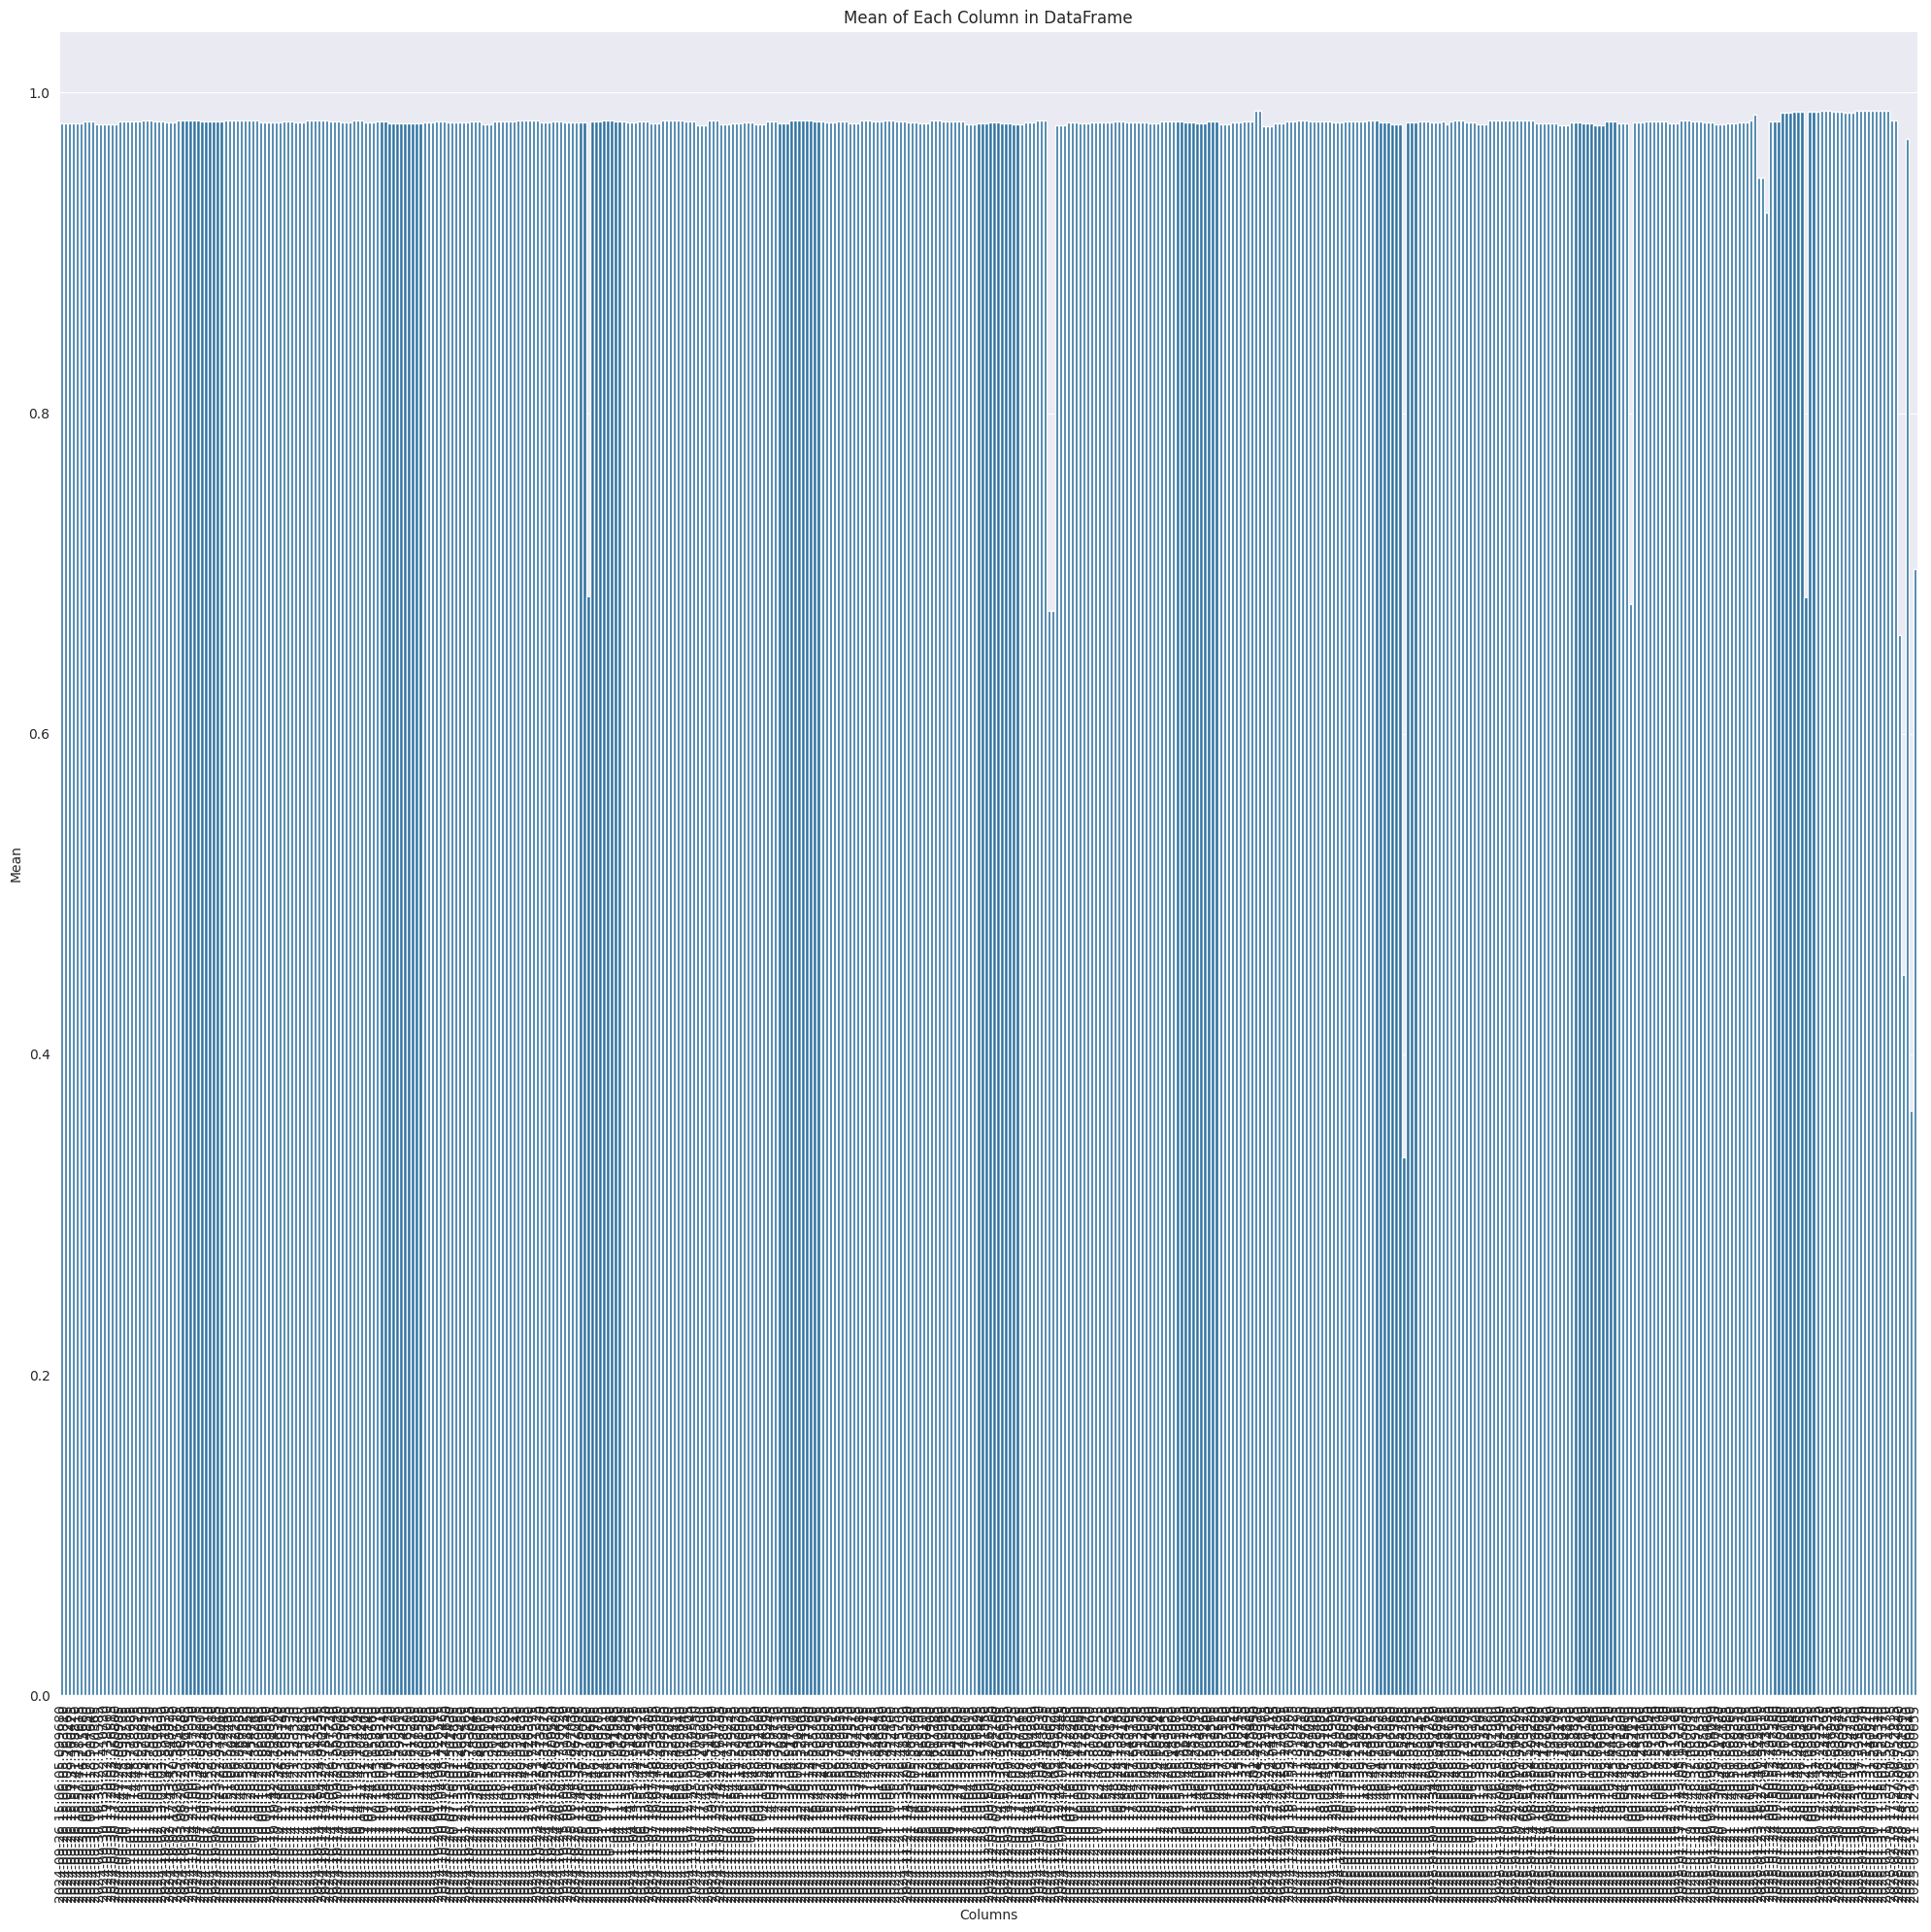

In [130]:
summary = df.describe()

# Extract the mean values
mean_values = summary.loc['mean']

#mean_values = mean_values.dropna()
filtered_mean_values = mean_values[mean_values.between(0.1,0.99)]

# Create a Seaborn barplot
plt.figure(figsize=(20, 20))
sns.barplot(x=filtered_mean_values.index, y=filtered_mean_values.values)

# Add labels and title
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.xlabel('Columns')
plt.ylabel('Mean')
plt.title('Mean of Each Column in DataFrame')

# Show the plot
plt.tight_layout()
plt.show()

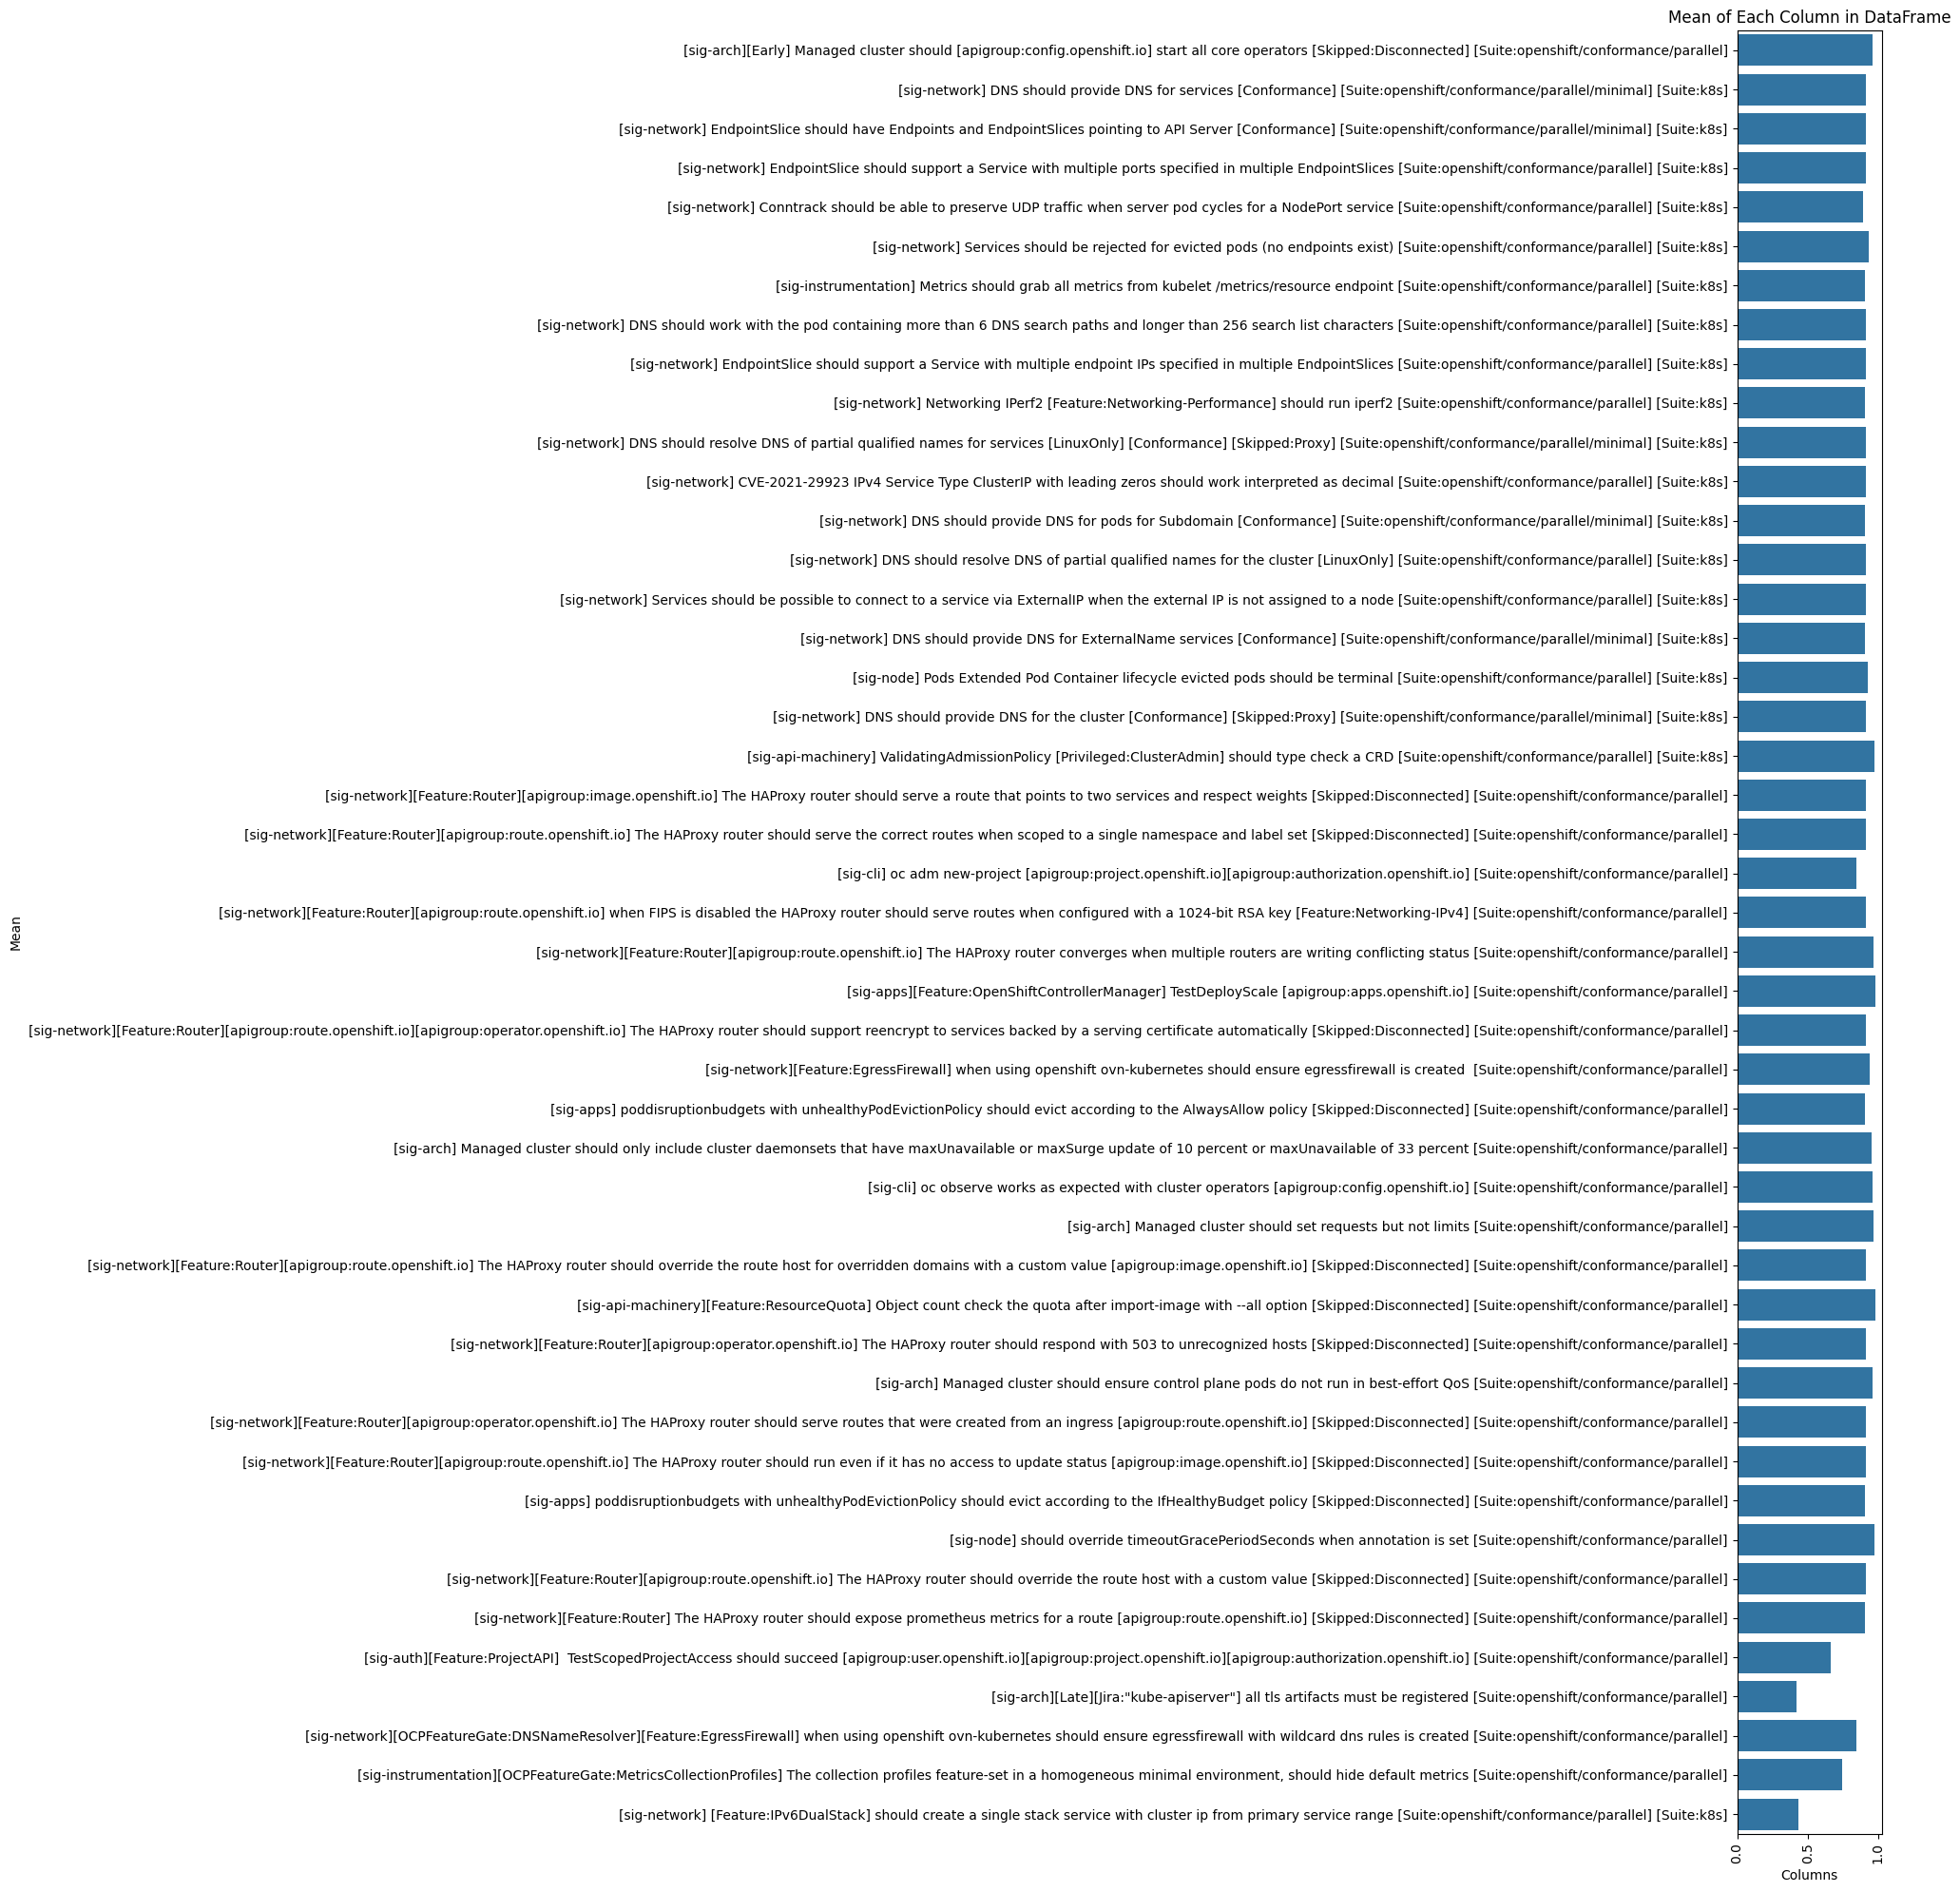

In [49]:
# chatgpt!
summary = df.T.describe()

# Extract the mean values
mean_values = summary.loc['mean']

mean_values = mean_values.dropna()
filtered_mean_values = mean_values[mean_values.between(0.1,0.98)]

# Create a Seaborn barplot
plt.figure(figsize=(20, 20))
sns.barplot(y=filtered_mean_values.index, x=filtered_mean_values.values, orient='h')

# Add labels and title
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.xlabel('Columns')
plt.ylabel('Mean')
plt.title('Mean of Each Column in DataFrame')

# Show the plot
plt.tight_layout()
plt.show()

In [25]:
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
df.columns = pd.to_numeric(df.columns)


# Split data into training and validation sets (optional, here we train on the whole set)

data = df.to_numpy()  # Convert the DataFrame to a NumPy array

# Step 1: Impute NaN values using SimpleImputer (fill NaNs with the column mean)
imputer = SimpleImputer(strategy='mean')  # You can use 'median' or 'most_frequent' as well
X_imputed = imputer.fit_transform(data)

# Step 2: Scale the data to the range [0, 1] using MinMaxScaler
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X_imputed)


# Step 1: Transpose the array to get shape (5083, 1909)
data_transposed = X_scaled.T  # This swaps rows and columns

# Step 2: Add an additional axis to make the shape (5083, 1909, 1)
data_reshaped = np.expand_dims(data_transposed, axis=-1)



# Split columns (datetimes) into train and test
x_train, x_test = train_test_split(data_reshaped, test_size=0.2, random_state=42)


print(x_train.shape, x_test.shape)



(4066, 1909, 1) (1017, 1909, 1)


In [26]:
x_train

array([[[1.        ],
        [1.        ],
        [1.        ],
        ...,
        [0.99874451],
        [0.99874451],
        [0.99874451]],

       [[1.        ],
        [1.        ],
        [1.        ],
        ...,
        [0.99936588],
        [0.99936588],
        [0.99936588]],

       [[1.        ],
        [1.        ],
        [1.        ],
        ...,
        [0.99804815],
        [0.99804815],
        [0.99804815]],

       ...,

       [[1.        ],
        [1.        ],
        [1.        ],
        ...,
        [0.99808795],
        [0.99808795],
        [0.99808795]],

       [[1.        ],
        [1.        ],
        [1.        ],
        ...,
        [0.99690019],
        [0.99690019],
        [0.99690019]],

       [[1.        ],
        [1.        ],
        [1.        ],
        ...,
        [0.99934896],
        [0.99934896],
        [0.99934896]]])

In [152]:
describe_t_df = df.T.describe()
print(describe_t_df.loc['mean'].mean())
print(describe_t_df.loc['std'].mean())


0.9332188692605526
0.03594883687705962


In [158]:
summary = df.describe()
mean_values = summary.loc['mean']
mean = summary.loc['mean'].mean()
std = summary.loc['std'].std()

#anomaly = mean - std / 2
anomaly = mean

print(f"anomaly: {anomaly}")

#mean_values = mean_values.dropna()
anomaly_values = mean_values[mean_values < anomaly]



anomaly: 0.9959402555987044


DatetimeIndex(['2024-09-26 15:06:05.099680', '2024-09-26 15:06:05.563810',
               '2024-09-26 15:06:08.769265', '2024-09-26 15:57:39.460425',
               '2024-09-26 15:57:41.378810', '2024-09-26 15:57:41.787615',
               '2024-09-30 09:20:16.215680', '2024-09-30 09:20:17.514850',
               '2024-09-30 09:20:18.907640', '2024-09-30 16:35:20.100365',
               ...
               '2025-03-12 17:26:48.364675', '2025-03-12 17:33:10.902920',
               '2025-03-12 18:12:59.322270', '2025-03-12 18:43:32.978585',
               '2025-03-13 14:39:50.218065', '2025-03-17 14:10:45.178675',
               '2025-03-20 00:46:29.412805', '2025-03-21 18:29:33.500655',
               '2025-03-24 12:31:17.645530', '2025-03-24 12:31:19.064710'],
              dtype='datetime64[ns]', length=622, freq=None)

In [28]:

import numpy as np
import keras
from keras import layers, models
from sklearn.model_selection import train_test_split

# Assuming data_reshaped is your input data of shape (5083, 1909, 1)
X = data_reshaped  # The reshaped data (features)

# Split into training and testing sets (80% train, 20% test)
#X_train, X_test = train_test_split(X, test_size=0.2, random_state=42)

# Define the autoencoder model
input_layer = layers.Input(shape=(X.shape[1], X.shape[2]))  # Shape (1909, 1)

# Encoder: Convolutional layers to compress the input data
x = layers.Conv1D(64, 3, activation='relu', padding='same')(input_layer)
x = layers.MaxPooling1D(2, padding='same')(x)
x = layers.Conv1D(32, 3, activation='relu', padding='same')(x)
x = layers.MaxPooling1D(2, padding='same')(x)

# Bottleneck (latent space)
x = layers.Conv1D(16, 3, activation='relu', padding='same')(x)

# Decoder: Transposed convolutional layers to reconstruct the data
x = layers.Conv1DTranspose(16, 3, activation='relu', padding='same')(x)
x = layers.UpSampling1D(2)(x)
x = layers.Conv1DTranspose(32, 3, activation='relu', padding='same')(x)
x = layers.UpSampling1D(2)(x)
x = layers.Conv1DTranspose(64, 3, activation='relu', padding='same')(x)

# Output layer: Same shape as input (1909, 1)
output_layer = layers.Conv1DTranspose(1, 3, activation='sigmoid', padding='same')(x)

# Create the autoencoder model
autoencoder = models.Model(input_layer, output_layer)


autoencoder.summary()

# Compile the model
autoencoder.compile(optimizer='adam', loss='mse')

# Train the model
autoencoder.fit(x_train, x_train, epochs=20, batch_size=32, validation_data=(x_test, x_test))

# Evaluate the model on the test set
loss = autoencoder.evaluate(x_test, x_test)
print(f"Test loss: {loss}")





Model: "functional_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_13 (InputLayer)     │ (None, 1909, 1)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_29 (Conv1D)              │ (None, 1909, 64)       │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_6 (MaxPooling1D)  │ (None, 955, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_30 (Conv1D)              │ (None, 955, 32)        │         6,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_7 (MaxPooling1D)  │ (None, 478, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_31 (Conv1D)              │ (None, 478, 16)        │         1,552 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_transpose_42             │ (None, 478, 16)        │           784 │
│ (Conv1DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling1d_6 (UpSampling1D)  │ (None, 956, 16)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_transpose_43             │ (None, 956, 32)        │         1,568 │
│ (Conv1DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling1d_7 (UpSampling1D)  │ (None, 1912, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_transpose_44             │ (None, 1912, 64)       │         6,208 │
│ (Conv1DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_transpose_45             │ (None, 1912, 1)        │           193 │
│ (Conv1DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,737 (65.38 KB)

 Trainable params: 16,737 (65.38 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20


ValueError: Dimensions must be equal, but are 1909 and 1912 for '{{node compile_loss/mse/sub}} = Sub[T=DT_FLOAT](data_1, functional_13_1/conv1d_transpose_45_1/Sigmoid)' with input shapes: [?,1909,1], [?,1912,1].

In [19]:


import keras
from keras import layers

model = keras.Sequential(
    [
        layers.Input(shape=(x_train.shape[1], x_train.shape[2])),
        layers.Conv1D(
            filters=32,
            kernel_size=7,
            padding="same",
            strides=3,
            activation="relu",
        ),
        layers.Dropout(rate=0.2),
        layers.Conv1D(
            filters=16,
            kernel_size=7,
            padding="same",
            strides=3,
            activation="relu",
        ),
        layers.Conv1DTranspose(
            filters=16,
            kernel_size=7,
            padding="same",
            strides=3,
            activation="relu",
        ),
        layers.Dropout(rate=0.2),
        layers.Conv1DTranspose(
            filters=32,
            kernel_size=7,
            padding="same",
            strides=3,
            activation="relu",
        ),
        layers.Conv1DTranspose(filters=1, kernel_size=7, padding="same"),
    ]
)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss="mse")
model.summary()


Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_18 (Conv1D)              │ (None, 637, 32)        │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 637, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_19 (Conv1D)              │ (None, 213, 16)        │         3,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_transpose_27             │ (None, 639, 16)        │         1,808 │
│ (Conv1DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 639, 16)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_transpose_28             │ (None, 1917, 32)       │         3,616 │
│ (Conv1DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_transpose_29             │ (None, 1917, 1)        │           225 │
│ (Conv1DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,505 (37.13 KB)

 Trainable params: 9,505 (37.13 KB)

 Non-trainable params: 0 (0.00 B)

In [12]:
history = model.fit(
    x_train,
    x_train,
    epochs=50,
    batch_size=128,
    validation_split=0.1,
    callbacks=[
        keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, mode="min")
    ],
)


Epoch 1/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: nan - val_loss: nan
Epoch 2/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: nan - val_loss: nan
Epoch 3/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: nan - val_loss: nan
Epoch 4/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: nan - val_loss: nan
Epoch 5/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: nan - val_loss: nan
Epoch 6/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: nan - val_loss: nan


In [183]:
reconstructed_data = autoencoder.predict(X_train)

# Calculate the reconstruction error (mean squared error)
mse = np.mean(np.power(X_train - reconstructed_data, 2), axis=1)

# Define a threshold for anomaly detection
threshold = np.percentile(mse, 95)  # Here, 95% percentile is used

# Identify anomalies based on the threshold
anomalies = mse > threshold

# Print out the anomalies
print(f"Anomalous test names: {df.index[anomalies]}")

60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 774us/step
Anomalous test names: Index([], dtype='object')


In [4]:
data = df.to_numpy()  # Convert the DataFrame to a NumPy array

# Step 1: Transpose the array to get shape (5083, 1909)
data_transposed = data.T  # This swaps rows and columns

# Step 2: Add an additional axis to make the shape (5083, 1909, 1)
data_reshaped = np.expand_dims(data_transposed, axis=-1)


data_reshaped.shape

(5083, 1909, 1)